In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import preprocessing

%matplotlib inline

In [2]:
train = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
test = pd.read_csv("../input/test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("../input/macro.csv", parse_dates=['timestamp'])
train = pd.merge(train, macro, how='left', on='timestamp')
test = pd.merge(test, macro, how='left', on='timestamp')
print(train.shape, test.shape)


(30471, 391) (7662, 390)


In [3]:
for f in train.columns:
    if train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values.astype("str")) + list(test[f].values.astype("str")))
        train[f]= lbl.transform(list(train[f].values.astype('str')))
        test[f]= lbl.transform(list(test[f].values.astype('str')))
        print (f+" Transformed")
        

product_type Transformed


sub_area Transformed


culture_objects_top_25 Transformed
thermal_power_plant_raion Transformed


incineration_raion Transformed
oil_chemistry_raion Transformed


radiation_raion Transformed
railroad_terminal_raion Transformed


big_market_raion Transformed
nuclear_reactor_raion Transformed


detention_facility_raion Transformed
water_1line Transformed


big_road1_1line Transformed
railroad_1line Transformed


ecology Transformed


child_on_acc_pre_school Transformed
modern_education_share Transformed


old_education_build_share Transformed


## Feature Engineering
Given that we have timestamp, we can create year and week based features. This can enable us to observe time based trends

In [4]:
train["year"] = train["timestamp"].dt.year
test["year"] = test["timestamp"].dt.year

train["month"] = train["timestamp"].dt.month
test["month"] = test["timestamp"].dt.month

train["weekofyear"] = train["timestamp"].dt.weekofyear
test["weekofyear"] = test["timestamp"].dt.weekofyear

train["weekday"] = train["timestamp"].dt.weekday
test["weekday"] = test["timestamp"].dt.weekday

train["yearmonth"] = train["timestamp"].dt.year*100 + train["timestamp"].dt.month
test["yearmonth"] = test["timestamp"].dt.year*100 + test["timestamp"].dt.month

train["yearmonth"] = train["timestamp"].dt.year*100 + train["timestamp"].dt.month
test["yearmonth"] = test["timestamp"].dt.year*100 + test["timestamp"].dt.month


/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


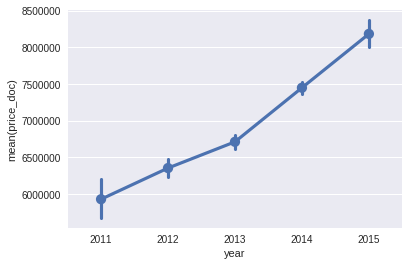

In [5]:
#plt.boxplot(train['price_doc'],train['year'])
sns.pointplot(x='year', y='price_doc', data=train)
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


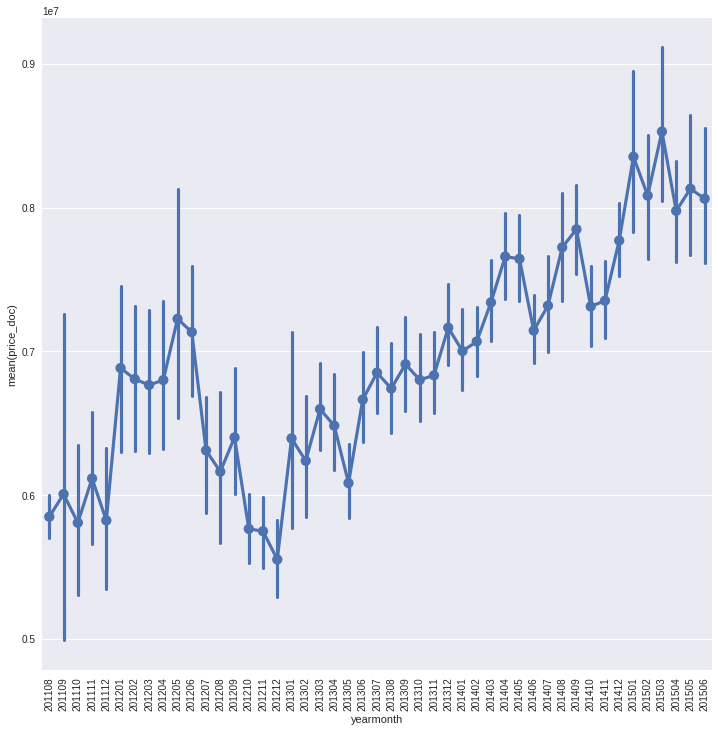

In [6]:
plt.figure(figsize=(12,12))
sns.pointplot(x='yearmonth', y='price_doc', data=train)
plt.xticks(rotation='vertical')
plt.show()

Essentially, the market had a decline around 201205 to 2013, before the prices started to increase.

Now let's look at the other factors like full_sq, life_sq, num_floor, max_floor (the base significant variables)

In [7]:
# ratio of living area to full area #
train["ratio_life_sq_full_sq"] = train["life_sq"] / np.maximum(train["full_sq"].astype("float"),1)
test["ratio_life_sq_full_sq"] = test["life_sq"] / np.maximum(test["full_sq"].astype("float"),1)
train["ratio_life_sq_full_sq"].ix[train["ratio_life_sq_full_sq"]<0] = 0
train["ratio_life_sq_full_sq"].ix[train["ratio_life_sq_full_sq"]>1] = 1
test["ratio_life_sq_full_sq"].ix[test["ratio_life_sq_full_sq"]<0] = 0
test["ratio_life_sq_full_sq"].ix[test["ratio_life_sq_full_sq"]>1] = 1

# ratio of kitchen area to living area #
train["ratio_kitch_sq_life_sq"] = train["kitch_sq"] / np.maximum(train["life_sq"].astype("float"),1)
test["ratio_kitch_sq_life_sq"] = test["kitch_sq"] / np.maximum(test["life_sq"].astype("float"),1)
train["ratio_kitch_sq_life_sq"].ix[train["ratio_kitch_sq_life_sq"]<0] = 0
train["ratio_kitch_sq_life_sq"].ix[train["ratio_kitch_sq_life_sq"]>1] = 1
test["ratio_kitch_sq_life_sq"].ix[test["ratio_kitch_sq_life_sq"]<0] = 0
test["ratio_kitch_sq_life_sq"].ix[test["ratio_kitch_sq_life_sq"]>1] = 1

# ratio of kitchen area to full area #
train["ratio_kitch_sq_full_sq"] = train["kitch_sq"] / np.maximum(train["full_sq"].astype("float"),1)
test["ratio_kitch_sq_full_sq"] = test["kitch_sq"] / np.maximum(test["full_sq"].astype("float"),1)
train["ratio_kitch_sq_full_sq"].ix[train["ratio_kitch_sq_full_sq"]<0] = 0
train["ratio_kitch_sq_full_sq"].ix[train["ratio_kitch_sq_full_sq"]>1] = 1
test["ratio_kitch_sq_full_sq"].ix[test["ratio_kitch_sq_full_sq"]<0] = 0
test["ratio_kitch_sq_full_sq"].ix[test["ratio_kitch_sq_full_sq"]>1] = 1


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
# floor of the house to the total number of floors in the house #
train["ratio_floor_max_floor"] = train["floor"] / train["max_floor"].astype("float")
test["ratio_floor_max_floor"] = test["floor"] / test["max_floor"].astype("float")

# num of floor from top #
train["floor_from_top"] = train["max_floor"] - train["floor"]
test["floor_from_top"] = test["max_floor"] - test["floor"]

In [9]:
train["extra_sq"] = train["full_sq"] - train["life_sq"]
test["extra_sq"] = test["full_sq"] - test["life_sq"]

In [10]:
train["age_of_building"] = train["build_year"] - train["year"]
test["age_of_building"] = test["build_year"] - test["year"]

## DATA VALIDATION

In [11]:
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"] , axis=1)
y_train = np.log1p(train.price_doc.values)

Now building a validation set

In [12]:
validation_set = 201407
dev_indices= np.where(x_train.yearmonth < validation_set)
val_indices = np.where(x_train.yearmonth >= validation_set)

x_dev = x_train.ix[dev_indices]
y_dev = y_train[dev_indices]

x_val = x_train.ix[val_indices]
y_val= y_train[val_indices]

print("training size: ", x_dev.shape , " validation size: ", x_val.shape)

training size:  (20483, 400)  validation size:  (9988, 400)


In [17]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'min_child_weight':1,
    'silent': 1,
    'seed':0
}

xgbtrain = xgb.DMatrix(x_dev,y_dev, feature_names=x_dev.columns)
xgbval = xgb.DMatrix(x_val,y_val, feature_names=x_val.columns)
xgbtest = xgb.DMatrix(x_test)

watchlist = [ (xgbtrain,'train'), (xgbval, 'test') ]
num_rounds =151

model = xgb.train(xgb_params, xgbtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=5)
best=model.best_iteration
print(best , "th round", " ", )

[0]	train-rmse:14.3248	test-rmse:14.4575


Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.



Will train until test-rmse hasn't improved in 50 rounds.


[5]	train-rmse:11.0906	test-rmse:11.2199


[10]	train-rmse:8.5889	test-rmse:8.70929


[15]	train-rmse:6.65425	test-rmse:6.77046


[20]	train-rmse:5.15975	test-rmse:5.2719


[25]	train-rmse:4.00552	test-rmse:4.11834


[30]	train-rmse:3.11607	test-rmse:3.22397


[35]	train-rmse:2.43156	test-rmse:2.53213


[40]	train-rmse:1.90712	test-rmse:2.00014


[45]	train-rmse:1.50788	test-rmse:1.59412


[50]	train-rmse:1.2062	test-rmse:1.28791


[55]	train-rmse:0.981973	test-rmse:1.05571


[60]	train-rmse:0.818513	test-rmse:0.88671


[65]	train-rmse:0.701717	test-rmse:0.760303


[70]	train-rmse:0.62038	test-rmse:0.668597


[75]	train-rmse:0.566003	test-rmse:0.60295


[80]	train-rmse:0.529966	test-rmse:0.556334


[85]	train-rmse:0.50654	test-rmse:0.528473


[90]	train-rmse:0.491434	test-rmse:0.504727


[95]	train-rmse:0.481579	test-rmse:0.488373


[100]	train-rmse:0.47529	test-rmse:0.476588


[105]	train-rmse:0.470403	test-rmse:0.468591


[110]	train-rmse:0.467338	test-rmse:0.463473


[115]	train-rmse:0.464564	test-rmse:0.458118


[120]	train-rmse:0.462414	test-rmse:0.453961


[125]	train-rmse:0.460494	test-rmse:0.452503


[130]	train-rmse:0.458928	test-rmse:0.451077


[135]	train-rmse:0.457343	test-rmse:0.450145


[140]	train-rmse:0.456141	test-rmse:0.449227


[145]	train-rmse:0.455089	test-rmse:0.448248


[150]	train-rmse:0.454026	test-rmse:0.447289


150 th round  


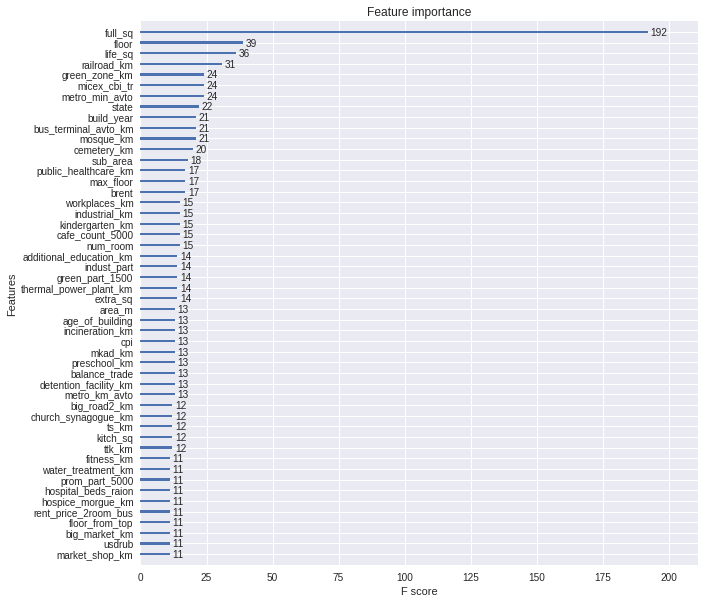

In [26]:
fig,ax =plt.subplots(figsize=(10,10))
xgb.plot_importance(model,max_num_features=50,ax=ax)
plt.show()

In [15]:

y_test = np.expm1(model.predict(xgbtest))
y_test



final= pd.DataFrame({'id':test.id, 'price_doc':y_test})
final.to_csv("result.csv")